In [ ]:
import glob
import functools
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import re

In [ ]:
import spacy
import pandas as pd
import requests
from spacy import displacy
# import en_core_web_sm

nlp = spacy.load('en_core_web_sm')

from spacy.tokens import Span
from spacy.matcher import Matcher

import matplotlib.pyplot as plot
from tqdm import tqdm
import networkx as ntx

%matplotlib inline

In [ ]:

import pandas as pd
data = pd.read_csv('All_Data\Generated_Data\all_input_docs_one_per_line.csv',header=None)
data.columns=['Text']
data.head()


,Text
0,Madan Mohan Choudhary v State of Bihar and Oth...
1,Simon and another v State of Karnataka Supreme...
2,Mahesh Kumar Bhawsinghka v State of Delhi Supr...
3,Union of India Others v Tushar Ranjan Mohanty ...
4,Union of India v Sher Singh and Others Supreme...


In [ ]:
sentences=[]
for text in data['Text']:
  list_of_sentences=text.split(".")
  filtered_list = [item for item in list_of_sentences if len(item) > 0]
  sentences.append(filtered_list)

print(sentences[0])
data['Sentences']=sentences

['Madan Mohan Choudhary v State of Bihar and Others Supreme Court of India  12 February 1999 Civil Appeal No', ' 787 of 1990 The Judgment was delivered by : S', ' Saghir Ahmad, J', ' Leave granted', ' 1', '  The recommendation of the High Court on the basis of which the appellant, who held the rank of Addl', ' District and Sessions Judge, was compulsorily retired from service, exhibits the tragic fact that the highest judicial body of the State which abhors anything done contrary to the rule of law or done in a whimsical manner or arbitrarily, can itself act in that manner on the administrative side', " Still, the plea that High Court Judges suffer from 'split personality' cannot be accepted for the pleasant fact that though on the administrative side they might have had acted as ordinary bureaucrat, once they don the robes they forget all their previous associations and connections", ' The transformation is so complete and real that even though they themselves were part of the decisio

In [ ]:
data.head()

,Text,Sentences
0,Madan Mohan Choudhary v State of Bihar and Oth...,[Madan Mohan Choudhary v State of Bihar and Ot...
1,Simon and another v State of Karnataka Supreme...,[Simon and another v State of Karnataka Suprem...
2,Mahesh Kumar Bhawsinghka v State of Delhi Supr...,[Mahesh Kumar Bhawsinghka v State of Delhi Sup...
3,Union of India Others v Tushar Ranjan Mohanty ...,[Union of India Others v Tushar Ranjan Mohanty...
4,Union of India v Sher Singh and Others Supreme...,[Union of India v Sher Singh and Others Suprem...


In [ ]:
!python -m spacy download en

#The SpaCy pipeline assigns word vectors, context-specific token vectors, part-of-speech tags,
#dependency parsing, and named entities

2023-10-05 10:27:46.556067: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 55.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [ ]:
def extract_entities(sents):
   # chunk one
   enti_one = ""
   enti_two = ""

   dep_prev_token = "" # dependency tag of previous token in sentence

   txt_prev_token = "" # previous token in sentence

   prefix = ""
   modifier = ""



   for tokn in nlp(sents):
       # chunk two
       ## move to next token if token is punctuation

       if tokn.dep_ != "punct":
           #  check if token is compound word or not
           if tokn.dep_ == "compound":
               prefix = tokn.text
               # add the current word to it if the previous word is 'compound’
               if dep_prev_token == "compound":
                   prefix = txt_prev_token + " "+ tokn.text

           # verify if token is modifier or not
           if tokn.dep_.endswith("mod") == True:
               modifier = tokn.text
               # add it to the current word if the previous word is 'compound'
               if dep_prev_token == "compound":
                   modifier = txt_prev_token + " "+ tokn.text

           # chunk3
           if tokn.dep_.find("subj") == True:
               enti_one = modifier +" "+ prefix + " "+ tokn.text
               prefix = ""
               modifier = ""
               dep_prev_token = ""
               txt_prev_token = ""

           # chunk4
           if tokn.dep_.find("obj") == True:
               enti_two = modifier +" "+ prefix +" "+ tokn.text

           # chunk 5
           # update variable
           dep_prev_token = tokn.dep_
           txt_prev_token = tokn.text

   return [enti_one.strip(), enti_two.strip()]

In [ ]:
extract_entities("The AbC-19 rapid antibody test is an immunological test for COVID-19 exposure developed by the UK Rapid Test")

['rapid antibody test', 'immunological UK Rapid Test']

In [ ]:
pairs_of_entities = []

for i in tqdm(data['Sentences'][:5]):
  for j in i:
   pairs_of_entities.append(extract_entities(j))

100%|██████████| 5/5 [00:08<00:00,  1.65s/it]


In [ ]:
print(pairs_of_entities)
pairs_of_entities[1:3]

[['', 'Others Supreme India'], ['Judgment', 'S'], ['', ''], ['Leave', ''], ['', ''], ['High who', 'Addl'], ['whimsical  itself', 'administrative  side'], ['they', 'previous  associations'], ['Indian  people', 'tremendous  faith'], ['however  order', 'compulsory  retirement'], ['', ''], ['High it', 'order'], ['service who', 'Temporary 15'], ['', ''], ['', ''], ['He', '8'], ['', ''], ['1980', '- 16'], ['', ''], ['', ''], ['He', 'Sub 19'], ['', ''], ['', ''], ['appellant', 'Superior Judicial Addl'], ['', 'District  15'], ['', ''], ['', ''], ['He', 'compulsory  post'], ['District appellant', 'capable work improvement'], ['Relation', 'Bar'], ['', ''], ['', 'work satisfactory'], ['', 'Bar'], ['', ''], ['He', ''], ['Judgments', 'average  quality'], ['Outturn', ''], ['', ''], ['', ''], ['work', 'whole'], ['Relationship', 'Bar'], ['He', ''], ['', ''], ['', ''], ['', ''], ['', 'good  Judgments'], ['', 'good  integrity'], ['', ''], ['', 'good  integrity'], ['', ''], ['', 'well Judicial Officer'],

[['Judgment', 'S'], ['', '']]

In [ ]:
def obtain_relation(sent):

   doc = nlp(sent)

   matcher = Matcher(nlp.vocab)

   pattern = [{'DEP':'ROOT'},
           {'DEP':'prep','OP':"?"},
           {'DEP':'agent','OP':"?"},
           {'POS':'ADJ','OP':"?"}]

   matcher.add("matching_1", [pattern])

   matcher = matcher(doc)

   if len(matcher)>2:
      h = len(matcher) - 1

      span = doc[matcher[h][1]:matcher[h][2]]
      return span.text

In [ ]:
# relations = [obtain_relation(j) for j in tqdm(data['Text'][:5])]
relations=[]
for j in tqdm(data['Sentences'][:5]):
  for i in j:
      relations.append(obtain_relation(i))

100%|██████████| 5/5 [00:06<00:00,  1.34s/it]


In [ ]:
source = [j[0] for j in pairs_of_entities]

#object extraction
target = [k[1] for k in pairs_of_entities]

data_kgf = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

In [ ]:
graph = ntx.from_pandas_edgelist(data_kgf, "source", "target",
                         edge_attr=True, create_using=ntx.MultiDiGraph())

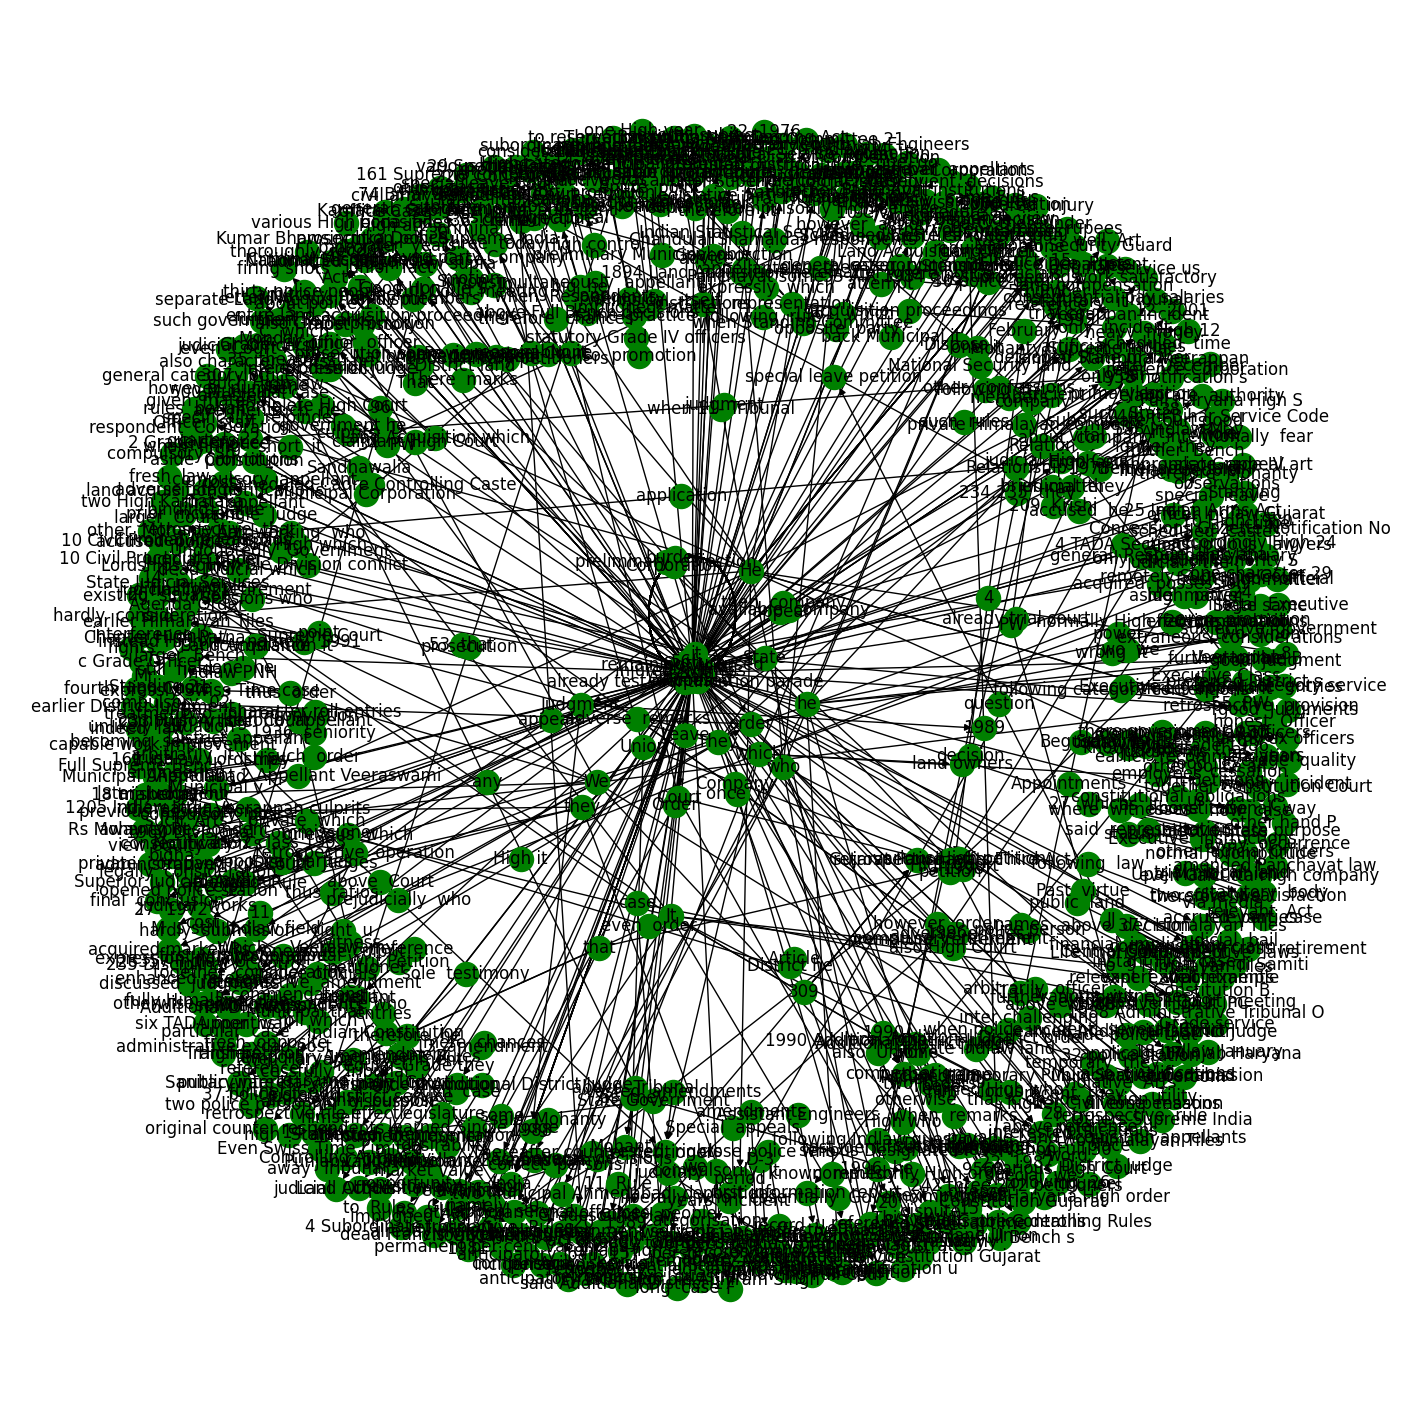

In [ ]:
plot.figure(figsize=(14, 14))
posn = ntx.spring_layout(graph)
ntx.draw(graph, with_labels=True, node_color='green', edge_cmap=plot.cm.Blues, pos = posn)
plot.show()

In [ ]:
# Read the text file and split sentences using '\n' as the delimiter
with open('C1.txt', 'r') as file:
    sentences = file.read().split('\n')

In [ ]:
# Create a DataFrame with a single column 'Sentences'
filtered_list = [item for item in sentences if len(item) > 0]
df = pd.DataFrame({'Sentences': filtered_list})


In [ ]:
df.head()

,Sentences
0,Masud Khan v State Of Uttar Pradesh
1,Supreme Court of India
2,26 September 1973
3,Writ Petition No. 117 of 1973
4,The Judgment was delivered by : A. Alagiriswam...


In [ ]:
new_entities=[]
for i in tqdm(df['Sentences']):
   new_entities.append(extract_entities(i))

100%|██████████| 18/18 [00:00<00:00, 66.61it/s]


In [ ]:
new_relations=[]
for j in tqdm(data['Sentences'][:18]):
      new_relations.append((obtain_relation(str(j))))

100%|██████████| 18/18 [00:07<00:00,  2.50it/s]


In [ ]:
source = [j[0] for j in new_entities]

#object extraction
target = [k[1] for k in new_entities]
print(len(source))
print(len(target))
print(len(relations))
data_kgf = pd.DataFrame({'source':source, 'target':target, 'edge':relations[:18]})

18
18
1050


In [ ]:
graph = ntx.from_pandas_edgelist(data_kgf, "source", "target",
                         edge_attr=True, create_using=ntx.MultiDiGraph())

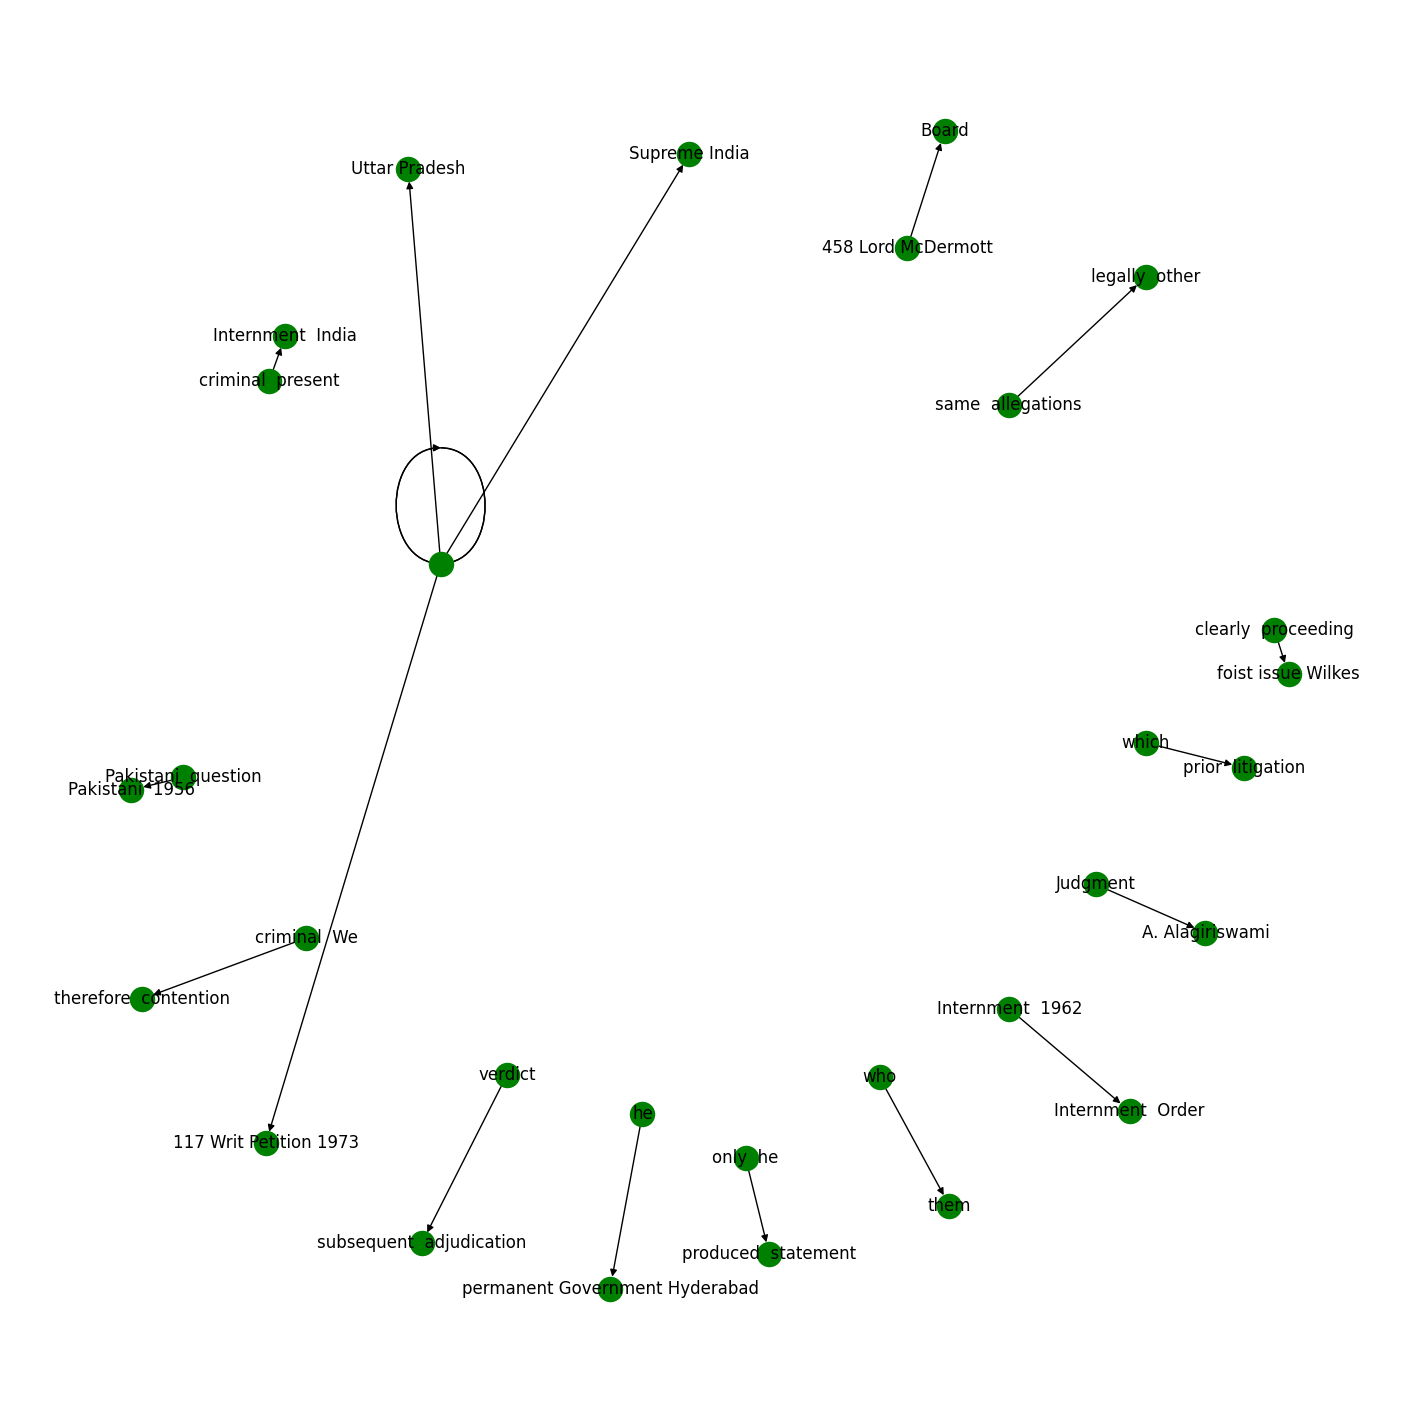

In [ ]:
plot.figure(figsize=(14, 14))
posn = ntx.spring_layout(graph)
ntx.draw(graph, with_labels=True, node_color='green', edge_cmap=plot.cm.Blues, pos = posn)
plot.show()